In [1]:
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read in average monthly temperature by state data
monthly_temps_path = 'Resources/average_monthly_temperature_by_state_1950-2022.csv'
monthly_temps_df = pd.read_csv(monthly_temps_path,
                               index_col='year')

In [3]:
# The Adidas dataset only has the two years 2020 & 2021, Clean for the relevant years
monthly_temps_df = monthly_temps_df.loc['2020':'2021']

monthly_temps_df = monthly_temps_df.rename_axis('Year')

# Clean columns
monthly_temps_df.drop(['Unnamed: 0', 'monthly_mean_from_1901_to_2000', 'centroid_lon', 'centroid_lat'], axis=1, inplace=True)

monthly_temps_df = monthly_temps_df.rename(
    columns={
        'month': 'Month',
        'state': 'State',
        'average_temp': 'Average Temp'
    }
)

In [4]:
monthly_temps_df.head()

,Month,State,Average Temp
Year,,,
2020,1,Alabama,50.4
2020,1,Arizona,43.0
2020,1,Arkansas,44.8
2020,1,California,44.8
2020,1,Colorado,27.8


In [5]:
# Resetting index to prep 'Year' for datetime type conversion
monthly_temps_df = monthly_temps_df.reset_index()

In [6]:
# Merging Year and Month columns as a datetime dtype
monthly_temps_df['Date'] = pd.to_datetime(monthly_temps_df['Year'].astype(str) + '-' + monthly_temps_df['Month'].astype(str).str.zfill(2))

# Dropping the irrelevent 'Days' as they all show as xx-xx-01
monthly_temps_df['Date'] = monthly_temps_df['Date'].dt.to_period('M')

# Setting index to the new datetime 'Date' column
monthly_temps_df = monthly_temps_df.set_index('Date')

# Dropping the now irrelevant duplicate columns
monthly_temps_df.drop(['Year', 'Month'], axis=1, inplace=True)


In [7]:
# Check the dtype conversion is correct
monthly_temps_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1152 entries, 2020-01 to 2021-12
Freq: M
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         1152 non-null   object 
 1   Average Temp  1152 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.0+ KB


In [8]:
# Check the formatting is correct
display(monthly_temps_df.head(10))
display(monthly_temps_df.tail(10))

,State,Average Temp
Date,,
2020-01,Alabama,50.4
2020-01,Arizona,43.0
2020-01,Arkansas,44.8
2020-01,California,44.8
2020-01,Colorado,27.8
2020-01,Connecticut,32.4
2020-01,Delaware,40.1
2020-01,Florida,62.8
2020-01,Georgia,51.8


,State,Average Temp
Date,,
2021-12,South Dakota,31.4
2021-12,Tennessee,48.0
2021-12,Texas,58.2
2021-12,Utah,36.8
2021-12,Vermont,31.2
2021-12,Virginia,45.2
2021-12,Washington,34.7
2021-12,West Virginia,41.8
2021-12,Wisconsin,29.3


In [9]:
# Groupby State, Year, and Month to sort
monthly_temps_by_state = monthly_temps_df.groupby(['State', monthly_temps_df.index.year, monthly_temps_df.index.month])['Average Temp'].sum()

display(monthly_temps_by_state.head(10))
display(monthly_temps_by_state.tail(10))

State    Date  Date
Alabama  2020  1       50.4
               2       50.2
               3       57.2
               4       62.8
               5       65.4
               6       72.9
               7       78.9
               8       80.6
               9       77.2
               10      70.6
Name: Average Temp, dtype: float64

State    Date  Date
Wyoming  2021  3       24.8
               4       35.0
               5       43.4
               6       56.8
               7       67.4
               8       67.1
               9       61.1
               10      51.0
               11      40.2
               12      31.3
Name: Average Temp, dtype: float64

In [10]:
# Rename the Indexes
monthly_temps_by_state.index.names = ['State', 'Year', 'Month']

monthly_temps_by_state.head()

State    Year  Month
Alabama  2020  1        50.4
               2        50.2
               3        57.2
               4        62.8
               5        65.4
Name: Average Temp, dtype: float64

In [11]:
# Save Cleaned temperature data csv
monthly_temps_by_state.to_csv('Resources/avg_temps_cleaned.csv')


In [12]:
# Read in the Adidas xlsx
adidas_path = 'Resources/Adidas US Sales Datasets.xlsx'
adidas_df = pd.read_excel(adidas_path,
                          index_col='Unnamed: 3',
                          parse_dates=True,
                          date_format='dateutil')


In [13]:
# See what we're dealing with
adidas_df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
NaN,NaN,NaN,Adidas Sales Database,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Invoice Date,NaN,Retailer,Retailer ID,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
2020-01-01 00:00:00,NaN,Foot Locker,1185732,Northeast,New York,New York,Men's Street Footwear,50,1200,600000,300000,0.5,In-store


In [14]:
adidas_df['Unnamed: 4'].unique()

array([nan, 'Region', 'Northeast', 'South', 'West', 'Midwest',
       'Southeast'], dtype=object)

In [15]:
# Clean for relevent data to include Region, State, Product, Price per Unit, Units Sold, and Total Sales

adidas_df = adidas_df.rename_axis('Invoice Date')
adidas_df.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'], axis=1, inplace=True)
adidas_df = adidas_df.rename(
    columns={
        'Unnamed: 4': 'Region',
        'Unnamed: 5': 'State',
        'Unnamed: 7': 'Product',
        'Unnamed: 8': 'Price per Unit',
        'Unnamed: 9': 'Units Sold',
        'Unnamed: 10': 'Total Sales',
    }
)

# Drop NaNs
adidas_df.dropna(inplace=True)

In [16]:
# Reset index to prep for datetime conversion
adidas_df = adidas_df.reset_index()

# The first row seems to be all strings leftover from xcels column format, dropping that
adidas_df.drop(0, axis=0, inplace=True)

# Coverting invoice date column to datetime
adidas_df['Date'] = pd.to_datetime(adidas_df['Invoice Date'])

# Setting the datetime column to the index
adidas_df = adidas_df.set_index('Date')

# Dropping the now irrelevant duplicate column
adidas_df.drop('Invoice Date', axis=1, inplace=True)

# Sorting the dates
adidas_df = adidas_df.sort_index()

display(adidas_df.head(10))
display(adidas_df.tail(10))

,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2020-01-01,Northeast,New York,Men's Street Footwear,50,1200,600000
2020-01-01,Northeast,Pennsylvania,Women's Apparel,75,275,206250
2020-01-01,Northeast,Pennsylvania,Women's Apparel,53,83,4399
2020-01-01,Northeast,New York,Men's Street Footwear,47,336,15792
2020-01-01,Northeast,New York,Men's Street Footwear,34,384,13056
2020-01-01,Northeast,Pennsylvania,Women's Apparel,68,83,5644
2020-01-02,Northeast,Pennsylvania,Men's Street Footwear,32,122,3904
2020-01-02,Northeast,Pennsylvania,Men's Street Footwear,27,158,4266
2020-01-02,Northeast,New York,Men's Athletic Footwear,36,320,11520


,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2021-12-30,Northeast,Pennsylvania,Women's Athletic Footwear,60.0,175,105000.0
2021-12-30,Northeast,Pennsylvania,Women's Athletic Footwear,57,53,3021
2021-12-30,Northeast,Maine,Women's Athletic Footwear,42,36,1512
2021-12-30,Northeast,Pennsylvania,Women's Athletic Footwear,40,53,2120
2021-12-30,Northeast,Maine,Women's Athletic Footwear,45,125,56250
2021-12-31,Northeast,Pennsylvania,Men's Apparel,70,175,122500
2021-12-31,Northeast,Pennsylvania,Men's Apparel,63,47,2961
2021-12-31,Northeast,Pennsylvania,Men's Apparel,46,56,2576
2021-12-31,Northeast,Maine,Men's Apparel,52,36,1872


In [17]:
#checking how regions sort
adidas_region = adidas_df.sort_values('Region')

display(adidas_region.head(30))
display(adidas_region.tail(30))

,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2021-08-13,Midwest,Kansas,Women's Athletic Footwear,37,90,3330
2021-01-10,Midwest,Wisconsin,Women's Apparel,32,84,2688
2021-09-07,Midwest,Iowa,Women's Apparel,40,225,90000
2021-09-07,Midwest,Iowa,Women's Apparel,36,61,2196
2021-06-17,Midwest,Illinois,Women's Apparel,50,225,112500
2021-06-17,Midwest,Michigan,Women's Apparel,65,675,438750
2021-06-17,Midwest,Michigan,Women's Athletic Footwear,45,525,236250
2021-01-10,Midwest,Wisconsin,Men's Apparel,41,58,2378
2021-01-10,Midwest,Wisconsin,Men's Athletic Footwear,32,78,2496


,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2021-09-12,West,Utah,Women's Athletic Footwear,7,111,777
2021-09-12,West,Utah,Women's Apparel,18,132,2376
2021-09-12,West,Utah,Men's Athletic Footwear,23,122,2806
2021-09-12,West,Utah,Women's Street Footwear,7,105,735
2021-01-09,West,California,Women's Athletic Footwear,59,210,12390
2021-01-09,West,California,Women's Athletic Footwear,41,224,9184
2021-05-20,West,Alaska,Men's Apparel,62,69,4278
2021-09-11,West,Hawaii,Women's Apparel,56,105,5880
2021-09-11,West,Hawaii,Women's Athletic Footwear,62,85,5270


In [18]:
#Dropping the days
adidas_df = adidas_df.reset_index()
adidas_df['Date'] = adidas_df['Date'].dt.to_period('M')

adidas_df = adidas_df.set_index('Date')
adidas_df.head(10)

,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2020-01,Northeast,New York,Men's Street Footwear,50,1200,600000
2020-01,Northeast,Pennsylvania,Women's Apparel,75,275,206250
2020-01,Northeast,Pennsylvania,Women's Apparel,53,83,4399
2020-01,Northeast,New York,Men's Street Footwear,47,336,15792
2020-01,Northeast,New York,Men's Street Footwear,34,384,13056
2020-01,Northeast,Pennsylvania,Women's Apparel,68,83,5644
2020-01,Northeast,Pennsylvania,Men's Street Footwear,32,122,3904
2020-01,Northeast,Pennsylvania,Men's Street Footwear,27,158,4266
2020-01,Northeast,New York,Men's Athletic Footwear,36,320,11520


In [19]:
# checking dtypes
adidas_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 9648 entries, 2020-01 to 2021-12
Freq: M
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Region          9648 non-null   object
 1   State           9648 non-null   object
 2   Product         9648 non-null   object
 3   Price per Unit  9648 non-null   object
 4   Units Sold      9648 non-null   object
 5   Total Sales     9648 non-null   object
dtypes: object(6)
memory usage: 527.6+ KB


In [20]:
# Convert columns to dtype 'int' where needed
adidas_df[['Price per Unit', 'Units Sold', 'Total Sales']] = adidas_df[['Price per Unit', 'Units Sold', 'Total Sales']].astype(int)

adidas_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 9648 entries, 2020-01 to 2021-12
Freq: M
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Region          9648 non-null   object
 1   State           9648 non-null   object
 2   Product         9648 non-null   object
 3   Price per Unit  9648 non-null   int32 
 4   Units Sold      9648 non-null   int32 
 5   Total Sales     9648 non-null   int32 
dtypes: int32(3), object(3)
memory usage: 414.6+ KB


In [21]:
adidas_df['Total Sales'] = adidas_df['Price per Unit'] * adidas_df['Units Sold']

adidas_df.head()

,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2020-01,Northeast,New York,Men's Street Footwear,50,1200,60000
2020-01,Northeast,Pennsylvania,Women's Apparel,75,275,20625
2020-01,Northeast,Pennsylvania,Women's Apparel,53,83,4399
2020-01,Northeast,New York,Men's Street Footwear,47,336,15792
2020-01,Northeast,New York,Men's Street Footwear,34,384,13056


In [22]:
adidas_df['Product'].unique()

array(["Men's Street Footwear", "Women's Apparel",
       "Men's Athletic Footwear", "Women's Street Footwear",
       "Women's Athletic Footwear", "Men's Apparel"], dtype=object)

In [23]:
adidas_by_month = adidas_df.groupby(['State', adidas_df.index.year, adidas_df.index.month,'Region', 'Product'])[['Units Sold', 'Total Sales']].sum()
adidas_by_month = pd.DataFrame(adidas_by_month)
adidas_by_month.head(20)

Units Sold  Total Sales
State   Date Date Region Product                                           
Alabama 2021 8    South  Men's Apparel                    2430        91281
                         Men's Athletic Footwear          4146       111112
                         Men's Street Footwear            5334       129295
                         Women's Apparel                  4189       137378
                         Women's Athletic Footwear        2561        75010
                         Women's Street Footwear          3084        64769
             9    South  Men's Apparel                    3370       149180
                         Men's Athletic Footwear          5431       247776
                         Men's Street Footwear            5323       191497
                         Women's Apparel                  5460       265670
                         Women's Athletic Footwear        3682       161302
                         Women's Street Footwear          5880       267548
             10   South  Men's Apparel                    1485        76276
                         Men's Athletic Footwear          2655       103471
                         Men's Street Footwear            1955        96814
                         Women's Apparel                  2179       135392
                         Women's Athletic Footwear        1760        90871
                         Women's Street Footwear          2403       116607
Alaska  2021 1    West   Men's Apparel                     221        10866
                         Men's Athletic Footwear           484        21562

In [24]:
adidas_by_month.index.names = ['State', 'Year', 'Month', 'Region', 'Product']

In [25]:
adidas_by_month = adidas_by_month.reset_index()

def gender(x):
    if 'Wo' in x:
        return "Women's"
    else:
        return "Men's"
    
adidas_by_month['Gender'] = adidas_by_month['Product'].apply(gender)

def subcategory(x):
    if 'Apparel' in x:
        return 'Apparel'
    elif 'Athletic' in x:
        return "Athletic Footwear"
    else:
        return "Street Footwear"
    
adidas_by_month['Subcategory'] = adidas_by_month['Product'].apply(subcategory)

display(adidas_by_month.head())
display(adidas_by_month.tail())

,State,Year,Month,Region,Product,Units Sold,Total Sales,Gender,Subcategory
0,Alabama,2021,8,South,Men's Apparel,2430,91281,Men's,Apparel
1,Alabama,2021,8,South,Men's Athletic Footwear,4146,111112,Men's,Athletic Footwear
2,Alabama,2021,8,South,Men's Street Footwear,5334,129295,Men's,Street Footwear
3,Alabama,2021,8,South,Women's Apparel,4189,137378,Women's,Apparel
4,Alabama,2021,8,South,Women's Athletic Footwear,2561,75010,Women's,Athletic Footwear


,State,Year,Month,Region,Product,Units Sold,Total Sales,Gender,Subcategory
3025,Wyoming,2021,12,West,Men's Athletic Footwear,768,34392,Men's,Athletic Footwear
3026,Wyoming,2021,12,West,Men's Street Footwear,1024,55648,Men's,Street Footwear
3027,Wyoming,2021,12,West,Women's Apparel,774,45744,Women's,Apparel
3028,Wyoming,2021,12,West,Women's Athletic Footwear,635,28440,Women's,Athletic Footwear
3029,Wyoming,2021,12,West,Women's Street Footwear,715,32010,Women's,Street Footwear


In [26]:
adidas_athletic_footwear = adidas_by_month[adidas_by_month['Subcategory'].str.contains('Athletic')]
display(adidas_athletic_footwear.head())
display(adidas_athletic_footwear.tail())
adidas_athletic_footwear['Subcategory'].unique()

,State,Year,Month,Region,Product,Units Sold,Total Sales,Gender,Subcategory
1,Alabama,2021,8,South,Men's Athletic Footwear,4146,111112,Men's,Athletic Footwear
4,Alabama,2021,8,South,Women's Athletic Footwear,2561,75010,Women's,Athletic Footwear
7,Alabama,2021,9,South,Men's Athletic Footwear,5431,247776,Men's,Athletic Footwear
10,Alabama,2021,9,South,Women's Athletic Footwear,3682,161302,Women's,Athletic Footwear
13,Alabama,2021,10,South,Men's Athletic Footwear,2655,103471,Men's,Athletic Footwear


,State,Year,Month,Region,Product,Units Sold,Total Sales,Gender,Subcategory
3016,Wyoming,2021,10,West,Women's Athletic Footwear,594,26254,Women's,Athletic Footwear
3019,Wyoming,2021,11,West,Men's Athletic Footwear,742,32889,Men's,Athletic Footwear
3022,Wyoming,2021,11,West,Women's Athletic Footwear,635,28170,Women's,Athletic Footwear
3025,Wyoming,2021,12,West,Men's Athletic Footwear,768,34392,Men's,Athletic Footwear
3028,Wyoming,2021,12,West,Women's Athletic Footwear,635,28440,Women's,Athletic Footwear


array(['Athletic Footwear'], dtype=object)

In [27]:
adidas_athletic_footwear = adidas_athletic_footwear.groupby(['State', 'Region', 'Year', 'Month', 'Gender', 'Subcategory'])[['Units Sold', 'Total Sales']].sum()
adidas_athletic_footwear = pd.DataFrame(adidas_athletic_footwear)
display(adidas_athletic_footwear.head(10))
display(adidas_athletic_footwear.tail(10))

Units Sold  Total Sales
State   Region Year Month Gender  Subcategory                               
Alabama South  2021 8     Men's   Athletic Footwear        4146       111112
                          Women's Athletic Footwear        2561        75010
                    9     Men's   Athletic Footwear        5431       247776
                          Women's Athletic Footwear        3682       161302
                    10    Men's   Athletic Footwear        2655       103471
                          Women's Athletic Footwear        1760        90871
Alaska  West   2021 1     Men's   Athletic Footwear         484        21562
                          Women's Athletic Footwear         281        12533
                    2     Men's   Athletic Footwear         763        36811
                          Women's Athletic Footwear         221        10829

Units Sold  Total Sales
State   Region Year Month Gender  Subcategory                               
Wyoming West   2021 8     Men's   Athletic Footwear         788        35134
                          Women's Athletic Footwear         672        26586
                    9     Men's   Athletic Footwear         750        33600
                          Women's Athletic Footwear         635        25130
                    10    Men's   Athletic Footwear         774        34656
                          Women's Athletic Footwear         594        26254
                    11    Men's   Athletic Footwear         742        32889
                          Women's Athletic Footwear         635        28170
                    12    Men's   Athletic Footwear         768        34392
                          Women's Athletic Footwear         635        28440

In [28]:
adidas_athletic_footwear = adidas_athletic_footwear.reset_index()

adidas_athletic_footwear = adidas_athletic_footwear.set_index(['State', 'Region', 'Year', 'Month'])

adidas_athletic_footwear.head()

Gender        Subcategory  Units Sold  Total Sales
State   Region Year Month                                                     
Alabama South  2021 8        Men's  Athletic Footwear        4146       111112
                    8      Women's  Athletic Footwear        2561        75010
                    9        Men's  Athletic Footwear        5431       247776
                    9      Women's  Athletic Footwear        3682       161302
                    10       Men's  Athletic Footwear        2655       103471

In [29]:
adidas_mens_athletic_footwear = adidas_athletic_footwear[adidas_athletic_footwear['Gender'].str.match("Men's")]
adidas_mens_athletic_footwear.head()

Gender        Subcategory  Units Sold  Total Sales
State   Region Year Month                                                   
Alabama South  2021 8      Men's  Athletic Footwear        4146       111112
                    9      Men's  Athletic Footwear        5431       247776
                    10     Men's  Athletic Footwear        2655       103471
Alaska  West   2021 1      Men's  Athletic Footwear         484        21562
                    2      Men's  Athletic Footwear         763        36811

In [30]:
adidas_mens_athletic_footwear = adidas_mens_athletic_footwear.groupby(['State', 'Region', 'Year', 'Month'])[['Units Sold', 'Total Sales']].sum()
adidas_mens_athletic_footwear= adidas_mens_athletic_footwear.rename(
    columns={
        'Price per Unit': '(M)Price per Unit',
        'Units Sold': '(M)Units Sold',
        'Total Sales': "Men's Athletic Footwear Sales"})
adidas_mens_athletic_footwear.head()

(M)Units Sold  Men's Athletic Footwear Sales
State   Region Year Month                                              
Alabama South  2021 8               4146                         111112
                    9               5431                         247776
                    10              2655                         103471
Alaska  West   2021 1                484                          21562
                    2                763                          36811

In [31]:
adidas_womens_athletic_footwear = adidas_athletic_footwear[adidas_athletic_footwear['Gender'].str.match("Women's")]
adidas_womens_athletic_footwear.head()

Gender        Subcategory  Units Sold  Total Sales
State   Region Year Month                                                     
Alabama South  2021 8      Women's  Athletic Footwear        2561        75010
                    9      Women's  Athletic Footwear        3682       161302
                    10     Women's  Athletic Footwear        1760        90871
Alaska  West   2021 1      Women's  Athletic Footwear         281        12533
                    2      Women's  Athletic Footwear         221        10829

In [32]:
adidas_womens_athletic_footwear = adidas_womens_athletic_footwear.groupby(['State', 'Region', 'Year', 'Month'])[['Units Sold', 'Total Sales']].sum()
adidas_womens_athletic_footwear= adidas_womens_athletic_footwear.rename(
    columns={
        'Price per Unit': '(W)Price per Unit',
        'Units Sold': '(W)Units Sold',
        'Total Sales': "Women's Athletic Footwear Sales"})
adidas_womens_athletic_footwear.head()

(W)Units Sold  Women's Athletic Footwear Sales
State   Region Year Month                                                
Alabama South  2021 8               2561                            75010
                    9               3682                           161302
                    10              1760                            90871
Alaska  West   2021 1                281                            12533
                    2                221                            10829

In [33]:
monthly_temps_by_state = monthly_temps_by_state.reset_index()



monthly_temps_by_state = monthly_temps_by_state.groupby(['State', 'Year', 'Month'])['Average Temp'].sum()

monthly_temps_by_state = pd.DataFrame(monthly_temps_by_state)

monthly_temps_by_state.head()

Average Temp
State   Year Month              
Alabama 2020 1              50.4
             2              50.2
             3              57.2
             4              62.8
             5              65.4

In [34]:
adidas_temps = adidas_mens_athletic_footwear.join(monthly_temps_by_state, on=['State', 'Year', 'Month'], how='left')
adidas_temps.head()

(M)Units Sold  Men's Athletic Footwear Sales  \
State   Region Year Month                                                 
Alabama South  2021 8               4146                         111112   
                    9               5431                         247776   
                    10              2655                         103471   
Alaska  West   2021 1                484                          21562   
                    2                763                          36811   

                           Average Temp  
State   Region Year Month                
Alabama South  2021 8              79.7  
                    9              76.9  
                    10             70.6  
Alaska  West   2021 1               NaN  
                    2               NaN

In [35]:
adidas_temps.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 507 entries, ('Alabama', 'South', 2021, 8) to ('Wyoming', 'West', 2021, 12)
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   (M)Units Sold                  507 non-null    int32  
 1   Men's Athletic Footwear Sales  507 non-null    int32  
 2   Average Temp                   483 non-null    float64
dtypes: float64(1), int32(2)
memory usage: 13.3+ KB


In [36]:
adidas_temps = pd.concat([adidas_temps, adidas_womens_athletic_footwear], axis=1).dropna()
display(adidas_temps.head(10))
display(adidas_temps.tail(10))

(M)Units Sold  Men's Athletic Footwear Sales  \
State   Region Year Month                                                 
Alabama South  2021 8               4146                         111112   
                    9               5431                         247776   
                    10              2655                         103471   
Arizona West   2021 1                760                          31581   
                    2                667                          28685   
                    3                561                          26468   
                    4                480                          24600   
                    5                604                          30790   
                    6                756                          38311   
                    7                830                          42495   

                           Average Temp  (W)Units Sold  \
State   Region Year Month                                
Alabama South  2021 8              79.7         2561.0   
                    9              76.9         3682.0   
                    10             70.6         1760.0   
Arizona West   2021 1              42.3          511.0   
                    2              44.6          356.0   
                    3              48.0          361.0   
                    4              55.4          403.0   
                    5              64.6          483.0   
                    6              74.4          550.0   
                    7              81.0          589.0   

                           Women's Athletic Footwear Sales  
State   Region Year Month                                   
Alabama South  2021 8                              75010.0  
                    9                             161302.0  
                    10                             90871.0  
Arizona West   2021 1                              21310.0  
                    2                              13162.0  
                    3                              17030.0  
                    4                              19070.0  
                    5                              23037.0  
                    6                              25860.0  
                    7                              27666.0

(M)Units Sold  Men's Athletic Footwear Sales  \
State   Region Year Month                                                 
Wyoming West   2021 3                656                          25847   
                    4                640                          25460   
                    5                677                          29857   
                    6                768                          34056   
                    7                788                          35297   
                    8                788                          35134   
                    9                750                          33600   
                    10               774                          34656   
                    11               742                          32889   
                    12               768                          34392   

                           Average Temp  (W)Units Sold  \
State   Region Year Month                                
Wyoming West   2021 3              24.8          512.0   
                    4              35.0          544.0   
                    5              43.4          581.0   
                    6              56.8          640.0   
                    7              67.4          650.0   
                    8              67.1          672.0   
                    9              61.1          635.0   
                    10             51.0          594.0   
                    11             40.2          635.0   
                    12             31.3          635.0   

                           Women's Athletic Footwear Sales  
State   Region Year Month                                   
Wyoming West   2021 3                              17696.0  
                    4                              18802.0  
                    5                              23109.0  
                    6                              25320.0  
                    7                              25850.0  
                    8                              26586.0  
                    9                              25130.0  
                    10                             26254.0  
                    11                             28170.0  
                    12                             28440.0

In [37]:
adidas_temps.columns

Index(['(M)Units Sold', 'Men's Athletic Footwear Sales', 'Average Temp',
       '(W)Units Sold', 'Women's Athletic Footwear Sales'],
      dtype='object')

In [38]:
adidas_temps = adidas_temps[['Average Temp', '(M)Units Sold', "Men's Athletic Footwear Sales", '(W)Units Sold', "Women's Athletic Footwear Sales"]]
display(adidas_temps.head(10))
display(adidas_temps.tail(10))

Average Temp  (M)Units Sold  \
State   Region Year Month                                
Alabama South  2021 8              79.7           4146   
                    9              76.9           5431   
                    10             70.6           2655   
Arizona West   2021 1              42.3            760   
                    2              44.6            667   
                    3              48.0            561   
                    4              55.4            480   
                    5              64.6            604   
                    6              74.4            756   
                    7              81.0            830   

                           Men's Athletic Footwear Sales  (W)Units Sold  \
State   Region Year Month                                                 
Alabama South  2021 8                             111112         2561.0   
                    9                             247776         3682.0   
                    10                            103471         1760.0   
Arizona West   2021 1                              31581          511.0   
                    2                              28685          356.0   
                    3                              26468          361.0   
                    4                              24600          403.0   
                    5                              30790          483.0   
                    6                              38311          550.0   
                    7                              42495          589.0   

                           Women's Athletic Footwear Sales  
State   Region Year Month                                   
Alabama South  2021 8                              75010.0  
                    9                             161302.0  
                    10                             90871.0  
Arizona West   2021 1                              21310.0  
                    2                              13162.0  
                    3                              17030.0  
                    4                              19070.0  
                    5                              23037.0  
                    6                              25860.0  
                    7                              27666.0

Average Temp  (M)Units Sold  \
State   Region Year Month                                
Wyoming West   2021 3              24.8            656   
                    4              35.0            640   
                    5              43.4            677   
                    6              56.8            768   
                    7              67.4            788   
                    8              67.1            788   
                    9              61.1            750   
                    10             51.0            774   
                    11             40.2            742   
                    12             31.3            768   

                           Men's Athletic Footwear Sales  (W)Units Sold  \
State   Region Year Month                                                 
Wyoming West   2021 3                              25847          512.0   
                    4                              25460          544.0   
                    5                              29857          581.0   
                    6                              34056          640.0   
                    7                              35297          650.0   
                    8                              35134          672.0   
                    9                              33600          635.0   
                    10                             34656          594.0   
                    11                             32889          635.0   
                    12                             34392          635.0   

                           Women's Athletic Footwear Sales  
State   Region Year Month                                   
Wyoming West   2021 3                              17696.0  
                    4                              18802.0  
                    5                              23109.0  
                    6                              25320.0  
                    7                              25850.0  
                    8                              26586.0  
                    9                              25130.0  
                    10                             26254.0  
                    11                             28170.0  
                    12                             28440.0

In [39]:
adidas_temps.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 483 entries, ('Alabama', 'South', 2021, 8) to ('Wyoming', 'West', 2021, 12)
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Average Temp                     483 non-null    float64
 1   (M)Units Sold                    483 non-null    int32  
 2   Men's Athletic Footwear Sales    483 non-null    int32  
 3   (W)Units Sold                    483 non-null    float64
 4   Women's Athletic Footwear Sales  483 non-null    float64
dtypes: float64(3), int32(2)
memory usage: 20.4+ KB


In [40]:
adidas_temps.index

MultiIndex([('Alabama', 'South', 2021,  8),
            ('Alabama', 'South', 2021,  9),
            ('Alabama', 'South', 2021, 10),
            ('Arizona',  'West', 2021,  1),
            ('Arizona',  'West', 2021,  2),
            ('Arizona',  'West', 2021,  3),
            ('Arizona',  'West', 2021,  4),
            ('Arizona',  'West', 2021,  5),
            ('Arizona',  'West', 2021,  6),
            ('Arizona',  'West', 2021,  7),
            ...
            ('Wyoming',  'West', 2021,  3),
            ('Wyoming',  'West', 2021,  4),
            ('Wyoming',  'West', 2021,  5),
            ('Wyoming',  'West', 2021,  6),
            ('Wyoming',  'West', 2021,  7),
            ('Wyoming',  'West', 2021,  8),
            ('Wyoming',  'West', 2021,  9),
            ('Wyoming',  'West', 2021, 10),
            ('Wyoming',  'West', 2021, 11),
            ('Wyoming',  'West', 2021, 12)],
           names=['State', 'Region', 'Year', 'Month'], length=483)

In [41]:
adidas_temps.loc['Arizona'].head(24)

Average Temp  (M)Units Sold  Men's Athletic Footwear Sales  \
Region Year Month                                                               
West   2021 1              42.3            760                          31581   
            2              44.6            667                          28685   
            3              48.0            561                          26468   
            4              55.4            480                          24600   
            5              64.6            604                          30790   
            6              74.4            756                          38311   
            7              81.0            830                          42495   
            8              80.4            926                          52417   
            9              77.2            937                          42829   
            10             67.4            820                          37590   
            11             57.9            835                          39206   
            12             50.7           1013                          46854   

                   (W)Units Sold  Women's Athletic Footwear Sales  
Region Year Month                                                  
West   2021 1              511.0                          21310.0  
            2              356.0                          13162.0  
            3              361.0                          17030.0  
            4              403.0                          19070.0  
            5              483.0                          23037.0  
            6              550.0                          25860.0  
            7              589.0                          27666.0  
            8              632.0                          32984.0  
            9              612.0                          25600.0  
            10             492.0                          20634.0  
            11             564.0                          23694.0  
            12             668.0                          28281.0

In [42]:
adidas_by_regions = adidas_temps.reset_index()
adidas_by_regions = adidas_by_regions.set_index(['Region', 'Year', 'Month'])
adidas_by_regions.drop(['State'], axis=1, inplace=True)
adidas_by_regions.head()

Average Temp  (M)Units Sold  Men's Athletic Footwear Sales  \
Region Year Month                                                               
South  2021 8              79.7           4146                         111112   
            9              76.9           5431                         247776   
            10             70.6           2655                         103471   
West   2021 1              42.3            760                          31581   
            2              44.6            667                          28685   

                   (W)Units Sold  Women's Athletic Footwear Sales  
Region Year Month                                                  
South  2021 8             2561.0                          75010.0  
            9             3682.0                         161302.0  
            10            1760.0                          90871.0  
West   2021 1              511.0                          21310.0  
            2              356.0                          13162.0

In [43]:
adidas_temps = adidas_temps.reset_index()
adidas_temps.head()

,State,Region,Year,Month,Average Temp,(M)Units Sold,Men's Athletic Footwear Sales,(W)Units Sold,Women's Athletic Footwear Sales
0,Alabama,South,2021,8,79.7,4146,111112,2561.0,75010.0
1,Alabama,South,2021,9,76.9,5431,247776,3682.0,161302.0
2,Alabama,South,2021,10,70.6,2655,103471,1760.0,90871.0
3,Arizona,West,2021,1,42.3,760,31581,511.0,21310.0
4,Arizona,West,2021,2,44.6,667,28685,356.0,13162.0


In [44]:
adidas_temps.drop('Year', axis=1, inplace=True)
adidas_temps = adidas_temps.sort_values('Average Temp', ascending=True)

adidas_temps = adidas_temps.set_index('State')
adidas_temps.head()

,Region,Month,Average Temp,(M)Units Sold,Men's Athletic Footwear Sales,(W)Units Sold,Women's Athletic Footwear Sales
State,,,,,,,
North Dakota,Midwest,2,13.4,195,5760,130.0,3870.0
Wisconsin,Midwest,2,15.4,252,8768,95.0,2335.0
Iowa,Midwest,2,18.2,189,5631,98.0,2450.0
South Dakota,Midwest,2,19.6,226,7859,125.0,4325.0
Vermont,Northeast,2,19.6,410,19020,243.0,9060.0


In [45]:
adidas_temps.info()

<class 'pandas.core.frame.DataFrame'>
Index: 483 entries, North Dakota to Texas
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Region                           483 non-null    object 
 1   Month                            483 non-null    int64  
 2   Average Temp                     483 non-null    float64
 3   (M)Units Sold                    483 non-null    int32  
 4   Men's Athletic Footwear Sales    483 non-null    int32  
 5   (W)Units Sold                    483 non-null    float64
 6   Women's Athletic Footwear Sales  483 non-null    float64
dtypes: float64(3), int32(2), int64(1), object(1)
memory usage: 26.4+ KB


In [46]:
adidas_temps["Men's Athletic Footwear Sales"] = adidas_temps["Men's Athletic Footwear Sales"].astype(int)
adidas_temps['(M)Units Sold'] = adidas_temps['(M)Units Sold'].astype(int)
adidas_temps.info()

<class 'pandas.core.frame.DataFrame'>
Index: 483 entries, North Dakota to Texas
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Region                           483 non-null    object 
 1   Month                            483 non-null    int64  
 2   Average Temp                     483 non-null    float64
 3   (M)Units Sold                    483 non-null    int32  
 4   Men's Athletic Footwear Sales    483 non-null    int32  
 5   (W)Units Sold                    483 non-null    float64
 6   Women's Athletic Footwear Sales  483 non-null    float64
dtypes: float64(3), int32(2), int64(1), object(1)
memory usage: 26.4+ KB


In [47]:
adidas_mens_temps = adidas_temps[['Month', 'Average Temp', '(M)Units Sold', 'Men\'s Athletic Footwear Sales']]
adidas_mens_temps.head()

,Month,Average Temp,(M)Units Sold,Men's Athletic Footwear Sales
State,,,,
North Dakota,2,13.4,195,5760
Wisconsin,2,15.4,252,8768
Iowa,2,18.2,189,5631
South Dakota,2,19.6,226,7859
Vermont,2,19.6,410,19020


In [48]:
adidas_womens_temps = adidas_temps[['Month', 'Average Temp', '(W)Units Sold', 'Women\'s Athletic Footwear Sales']]
adidas_womens_temps.head()

,Month,Average Temp,(W)Units Sold,Women's Athletic Footwear Sales
State,,,,
North Dakota,2,13.4,130.0,3870.0
Wisconsin,2,15.4,95.0,2335.0
Iowa,2,18.2,98.0,2450.0
South Dakota,2,19.6,125.0,4325.0
Vermont,2,19.6,243.0,9060.0


In [49]:
adidas_mens_temps = adidas_mens_temps.sort_values('Month', ascending=True)

In [50]:
avg_temp_arizona = adidas_mens_temps['Average Temp'].loc['Arizona']
total_sales_arizona = adidas_mens_temps['Men\'s Athletic Footwear Sales'].loc['Arizona']
arizona_months = adidas_mens_temps['Month'].loc['Arizona']

In [51]:
arizona_merged = pd.concat([arizona_months, avg_temp_arizona, total_sales_arizona], axis=1)
arizona_merged.head(12)

,Month,Average Temp,Men's Athletic Footwear Sales
State,,,
Arizona,1,42.3,31581
Arizona,2,44.6,28685
Arizona,3,48.0,26468
Arizona,4,55.4,24600
Arizona,5,64.6,30790
Arizona,6,74.4,38311
Arizona,7,81.0,42495
Arizona,8,80.4,52417
Arizona,9,77.2,42829


In [52]:
arizona_merged = arizona_merged.sort_values('Average Temp', ascending=True)
arizona_merged.head(12)

,Month,Average Temp,Men's Athletic Footwear Sales
State,,,
Arizona,1,42.3,31581
Arizona,2,44.6,28685
Arizona,3,48.0,26468
Arizona,12,50.7,46854
Arizona,4,55.4,24600
Arizona,11,57.9,39206
Arizona,5,64.6,30790
Arizona,10,67.4,37590
Arizona,6,74.4,38311


In [53]:
adidas_womens_temps = adidas_womens_temps.sort_values('Month', ascending=True)

total_sales_arizona_w = adidas_womens_temps['Women\'s Athletic Footwear Sales'].loc['Arizona']

arizona_womens_merged = pd.concat([arizona_months, avg_temp_arizona, total_sales_arizona_w], axis=1)
arizona_womens_merged.head(12)

,Month,Average Temp,Women's Athletic Footwear Sales
State,,,
Arizona,1,42.3,21310.0
Arizona,2,44.6,13162.0
Arizona,3,48.0,17030.0
Arizona,4,55.4,19070.0
Arizona,5,64.6,23037.0
Arizona,6,74.4,25860.0
Arizona,7,81.0,27666.0
Arizona,8,80.4,32984.0
Arizona,9,77.2,25600.0


In [54]:
arizona_womens_merged = arizona_womens_merged.sort_values('Average Temp', ascending=True)
arizona_womens_merged.head(12)

,Month,Average Temp,Women's Athletic Footwear Sales
State,,,
Arizona,1,42.3,21310.0
Arizona,2,44.6,13162.0
Arizona,3,48.0,17030.0
Arizona,12,50.7,28281.0
Arizona,4,55.4,19070.0
Arizona,11,57.9,23694.0
Arizona,5,64.6,23037.0
Arizona,10,67.4,20634.0
Arizona,6,74.4,25860.0


In [55]:
arizona_merged = arizona_merged.reset_index()
arizona_merged.drop(['State', 'Month'], axis=1, inplace=True)
arizona_merged = arizona_merged.set_index('Average Temp')
arizona_merged = arizona_merged.rename(
    columns={
        'Men\'s Athletic Footwear Sales': '(Arizona) Men\'s Athletic Footwear Sales'
    }
)
arizona_merged.head(12)

,(Arizona) Men's Athletic Footwear Sales
Average Temp,
42.3,31581
44.6,28685
48.0,26468
50.7,46854
55.4,24600
57.9,39206
64.6,30790
67.4,37590
74.4,38311


In [56]:
arizona_womens_merged = arizona_womens_merged.reset_index()
arizona_womens_merged.drop(['State', 'Month'], axis=1, inplace=True)
arizona_womens_merged = arizona_womens_merged.set_index('Average Temp')
arizona_womens_merged = arizona_womens_merged.rename(
    columns={
        'Women\'s Athletic Footwear Sales': '(Arizona) Women\'s Athletic Footwear Sales'
    }
)
arizona_womens_merged.head(12)

,(Arizona) Women's Athletic Footwear Sales
Average Temp,
42.3,21310.0
44.6,13162.0
48.0,17030.0
50.7,28281.0
55.4,19070.0
57.9,23694.0
64.6,23037.0
67.4,20634.0
74.4,25860.0


In [57]:
adidas_monthly_sales = adidas_df['Total Sales'].groupby(by=[adidas_df.index.year, adidas_df.index.month]).sum()

print(adidas_monthly_sales)

Date  Date
2020  1        2311271
      2        2140813
      3        2473102
      4        3192731
      5        2164764
      6        1083069
      7        2182388
      8        2641630
      9        2367686
      10       1428269
      11       1167975
      12       1077277
2021  1        7428996
      2        6117190
      3        5213682
      4        6490789
      5        8557211
      6        8703453
      7       10357931
      8        9642846
      9        8032173
      10       7101389
      11       7846245
      12      10326930
Name: Total Sales, dtype: int32


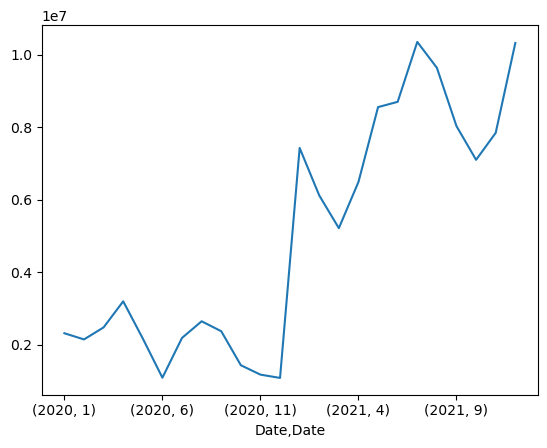

In [58]:
adidas_monthly_sales.plot()
pyplot.show()

In [59]:
adidas_2020_sales = adidas_monthly_sales.iloc[0: 12]
adidas_2020_sales.index.names = ['Year', 'Month']
adidas_2020_sales = adidas_2020_sales.reset_index()
adidas_2020_sales = pd.DataFrame(adidas_2020_sales)
adidas_2020_sales.drop('Year', axis=1, inplace=True)
adidas_2020_sales = adidas_2020_sales.set_index('Month')
adidas_2020_sales = adidas_2020_sales.rename(
    columns={
        'Total Sales': '2020 Total Sales per Month'
    }
)
adidas_2020_sales.head(12)

,2020 Total Sales per Month
Month,
1,2311271
2,2140813
3,2473102
4,3192731
5,2164764
6,1083069
7,2182388
8,2641630
9,2367686


In [60]:
adidas_2021_sales = adidas_monthly_sales.iloc[12:]
adidas_2021_sales.index.names = ['Year', 'Month']
adidas_2021_sales = adidas_2021_sales.reset_index()
adidas_2021_sales = pd.DataFrame(adidas_2021_sales)
adidas_2021_sales.drop('Year', axis=1, inplace=True)
adidas_2021_sales = adidas_2021_sales.set_index('Month')
adidas_2021_sales = adidas_2021_sales.rename(
    columns={
        'Total Sales': '2021 Total Sales per Month'
    }
)
adidas_2021_sales.head(12)

,2021 Total Sales per Month
Month,
1,7428996
2,6117190
3,5213682
4,6490789
5,8557211
6,8703453
7,10357931
8,9642846
9,8032173


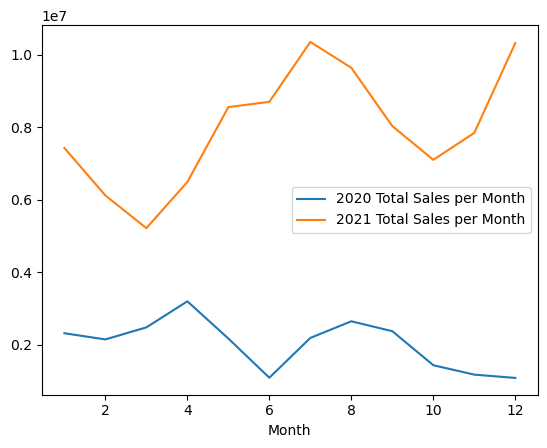

In [61]:
fig, ax = plt.subplots()

adidas_2020_sales.plot(ax=ax)
adidas_2021_sales.plot(ax=ax)
plt.show()

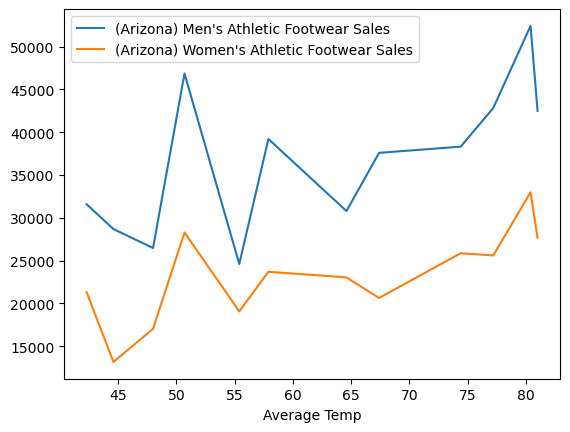

In [62]:
fig, ax = plt.subplots()


arizona_merged.plot(ax=ax)
arizona_womens_merged.plot(ax=ax)

plt.show()

In [63]:
adidas_monthly_sales_by_state = adidas_df.groupby(['State', adidas_df.index.year, adidas_df.index.month])['Total Sales'].sum()



print(adidas_monthly_sales_by_state)

State    Date  Date
Alabama  2021  8        608845
               9       1282973
               10       619431
Alaska   2021  1        128350
               2        191433
                        ...   
Wyoming  2021  8        222536
               9        207968
               10       218672
               11       220168
               12       231564
Name: Total Sales, Length: 509, dtype: int32


In [64]:
adidas_monthly_sales_by_state.info()

<class 'pandas.core.series.Series'>
MultiIndex: 509 entries, ('Alabama', 2021, 8) to ('Wyoming', 2021, 12)
Series name: Total Sales
Non-Null Count  Dtype
--------------  -----
509 non-null    int32
dtypes: int32(1)
memory usage: 4.1+ KB


In [65]:
display(adidas_monthly_sales_by_state.head(20))
display(adidas_monthly_sales_by_state.tail(20))

State    Date  Date
Alabama  2021  8        608845
               9       1282973
               10       619431
Alaska   2021  1        128350
               2        191433
               3        112015
               4        104013
               5        161790
               6        191481
               7        202757
               8        179038
               9        139235
               10       130429
               11       179711
               12        89726
Arizona  2021  1        162908
               2        128889
               3        134358
               4        158134
               5        182860
Name: Total Sales, dtype: int32

State      Date  Date
Wisconsin  2021  5        90592
                 6        78113
                 7       109528
                 8       107276
                 9        54882
                 10       64598
                 11       94755
                 12      145174
Wyoming    2021  1        87568
                 2       133001
                 3       162741
                 4       157030
                 5       201538
                 6       214731
                 7       224825
                 8       222536
                 9       207968
                 10      218672
                 11      220168
                 12      231564
Name: Total Sales, dtype: int32